In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name

In [3]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]
df= pd.read_csv(data_dir+'/cl3d.csv', usecols=columns, low_memory=True)

CPU times: user 15.4 s, sys: 2.45 s, total: 17.8 s
Wall time: 17.9 s


<string>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
df['genpart_pt'][df['sample']=='PU'].min()

nan

In [5]:
for samp in ['elec', 'pion', 'PU']:
    print(samp,len(df[df['sample']==samp]))

elec 279928
pion 9545
PU 29757


In [31]:
df['genpart_exeta'][df['sample']=='PU']=0
df['genpart_pt'][df['sample']=='PU']=0
df['matches'][df['sample']=='PU']=0

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel pac

# Config

In [32]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
bkg='pions' # 'pions' or 'PU'
#feature_set=5 # 1: minimal high level set 2: inclusive high level 3: set2 +layer 4: transverse + layers
#5:all high level for jb 6: set 3 but layer_pt/cl3d_pt
opti=False
res_dir=workdir+'/comparison_21Jun'
os.makedirs(res_dir, exist_ok=True)

In [33]:
%%time
#cut
algo_cut={}

def tolist(x):
    x.test=x.layer[1:-1].split(',')
    return x.test
print(len(df))

#cut on pt gen level for electrons and pions
sel=((df['genpart_pt']>genptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]

#cut on cl3d_pt for elec and pions
sel=((df['cl3d_pt'] > cl3dptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]
print('elec and pions pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))

#cut on cl3d_pt for PU
sel=((df_cut['cl3d_pt'] > PU_cut) & (df_cut['sample']=='PU')) | (df_cut['sample']!='PU')
df_cut=df_cut[sel]
print('PU pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#cut on hgcal eta acceptance
sel=((np.abs(df_cut['genpart_exeta'])>etamin) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df_cut[sel]
print('min eta cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
sel=((np.abs(df_cut['genpart_exeta'])<etamax) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df_cut[sel]
print('max eta cut : ',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#drop incomplete events
df_cut.dropna(inplace=True)
print('drpna : ', len(df_cut))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")




319230
elec and pions pt cut : 314710 275772
PU:  29757
PU pt cut : 314710 275772
PU:  29757


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


min eta cut : 294435 256235
PU:  29757


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


max eta cut :  262072 225066
PU:  29757
drpna :  262072
PU:  29757
cl3d eta cut: 261150 224441
PU:  29489
done
done layering36
CPU times: user 3min 29s, sys: 13.9 s, total: 3min 43s
Wall time: 3min 44s


In [34]:
# build new vars

#abseta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 5
maxlast=10

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= Sum/sumT
    
for n in range(1,maxlast):
    Sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        Sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= Sum/sumT
    
    

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        Sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= Sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5

#print('emax_1')
Sum=0
Sum+=df_cut['layer_{}'.format(maxpos)]
df_cut['Emax_1']=Sum/sumT
 
#print('emax_2L')
Sum=0
for i in range(maxpos-1, maxpos+1):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2L']=Sum/sumT
    
#print('emax_2R')
Sum=0
for i in range(maxpos, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2R']=Sum/sumT
    
#print('emax_3')
Sum=0
for i in range(maxpos-1, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_3']=Sum/sumT
#print('emax_4G')
Sum=0
for i in range(maxpos-2, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4L']=Sum/sumT
#print('emax_4R')
Sum=0
for i in range(maxpos-1, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4R']=Sum/sumT
#print('emax_5')
Sum=0
for i in range(maxpos-2, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_5']=Sum/sumT
    
    
    
    
    

In [35]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)

CPU times: user 6min 42s, sys: 14.3 s, total: 6min 57s
Wall time: 6min 49s


In [36]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='pion'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))

elif bkg == 'PU':
    data=df_cut[df_cut['sample']!='pions']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/exp_soft/llr/python/3.7.

signal weight = 1.0321688105114484, bkg weight =32.08601108033241


In [37]:

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pickle
features= data.columns.drop(['signal','weight','cl3d_pt', 'genpart_pt', 'genpart_exeta', 'sample', 'matches', 'layer_pt'])
#pickle.dump(scaler, open(f"{res_dir}/scaler_model.pkl", "wb"))
X_train, X_test, y_train, y_test = train_test_split(data[features], data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']], test_size=0.2,random_state=42)
y= data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']]
X=data[features]

In [38]:
balancing='comb'

In [39]:
# list BDTs to compare 
BDT_list={}
"""BDT = {'name' : '',
        'path' : '',
        'features' : "",
            }

"""
BDT_list[0]={'name' : 'baseline',
       'path' : '/res/res_pt20_vs{}_featset2/{}'.format(bkg, balancing),
       'features' :['cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer','cl3d_maxlayer','varee', 'varzz',
    'varpp', 'varrr',  'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
    'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta']
            }

BDT_list[1]={'name' : 'minimal',
       'path' : '/res/res_pt20_vs{}_featset3/{}'.format(bkg, balancing),
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT', 'cl3d_showerlength','cl3d_coreshowerlength'] #hoe/maxlayer

            }
"""
BDT_list[2]={'name' : 'minimal + EoT',
       'path' : '/res/res_pt20_vsPU_featset10_unstandardized',
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT']
            }
BDT_list[3]={'name' : 'minimal + hoe',
       'path' : '/res/res_pt20_vsPU_featset15_unstandardized',
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_hoe']
            }"""


BDT_list[2]={'name' : 'minimal + allnewvars',
       'path' : '/res/res_pt20_vs{}_featset4/{}'.format(bkg, balancing),
       'features' : ['cl3d_meanz','cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer',
                'abseta', 'varee', 'varpp', 'varzz', 'varrr',
                  'EoT', 'first_1', 'first_2',
                'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
                'last_5', 'last_6', 'last_7', 'last_8', 'last_9', 'firstHcal_1', 'firstHcal_2',
                'firstHcal_3', 'firstHcal_4', 'firstHcal_5', 'Emax_1', 'Emax_2L', 'Emax_2R', 'Emax_3',
                'Emax_4L', 'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']
}

"""BDT_list[5]={'name' : 'minimal + bestnewPU',
       'path' : '/res/res_pt20_vs{}_featset6/{}'.format(bkg, balancing),
       'features' : ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                 'ebm1', 'Emax_5', 'Emax_2R', 'first_4', 'Emax_4R', 'Emax_1']
            }"""

BDT_list[3]={'name' : 'minimal + bestnewpions',
       'path' : '/res/res_pt20_vs{}_featset5/{}'.format(bkg, balancing),
       'features' : ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_5', 'ebm1', 'first_5', 'Emax_4R', 'firstHcal_1', 'hbm']
      }
            

In [40]:
bkg

'pions'

In [41]:
X_test.columns

Index(['cl3d_eta', 'cl3d_showerlength', 'cl3d_coreshowerlength',
       'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax',
       'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax',
       'cl3d_srrmean', 'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10',
       'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta',
       'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5',
       'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11',
       'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17',
       'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23',
       'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29',
       'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35',
       'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2',
       'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
       'las

In [42]:
print('test')

test


balancing=['weights', 'ada', 'comb', 'SMOTE', 'under']
features=['cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer','cl3d_maxlayer','varee', 'varzz',
    'varpp', 'varrr',  'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
    'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta']
for i in balancing:
    print(i)
    bdt= '/res/res_pt20_vs{}_featset2/{}/model.model'.format(bkg,i )
    booster=xgb.Booster({'nthread' : 4})
    booster.load_model(workdir+bdt)
    test=xgb.DMatrix(data=X_test[features], label=y_test['signal'], feature_names=features)
    y_test[i] = booster.predict(test)
    matrix= xgb.DMatrix(data=X[features], label =y['signal'],  feature_names=features)
    y[i] = booster.predict(matrix)
#plot roc curves
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
roc_test={}
roc={}

for i in balancing:
    fpr, tpr, threshold = roc_curve(y['signal'].astype('int32'),y[i], pos_label=1)
    fpr.sort()
    tpr.sort()
    roc_auc = auc(fpr, tpr)
    roc[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    print(i)
    print ("AUC Score (Test): {:4%}".format(roc_auc))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(i, roc_auc))
    plt.yscale('log')
    plt.xlim(0.96,1.005)
    plt.ylim(1e-2, 1e-0)
    
 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROCall_{}.png'.format(bkg))

In [43]:

for i in BDT_list:
    print(BDT_list[i]['name'])
    bdt=BDT_list[i]
    booster=xgb.Booster({'nthread' : 4})
    booster.load_model(workdir+bdt['path']+'/model.model')
    test=xgb.DMatrix(data=X_test[bdt['features']], label=y_test['signal'], feature_names=bdt['features'], weight = y_test['weight'])
    y_test[bdt['name']] = booster.predict(test)
    matrix= xgb.DMatrix(data=X[bdt['features']], label =y['signal'],  feature_names=bdt['features'], weight = y['weight'])
    y[bdt['name']] = booster.predict(matrix)
    

    """if "unstandardized" not in BDT_list[i]['path']:
        print("loading scaler")
    #load scaler
        scaler=pickle.load(open( workdir + bdt['path']+ '/scaler_model.pkl', "rb" ) )

        test = xgb.DMatrix(data=scaler.transform(X_test[bdt['features']]),label=y_test['signal'],feature_names=bdt['features'], weight=y_test['weight'])
    else : 
        #print("Unstandardized")
        test=xgb.DMatrix(data=X_test[bdt['features']], label=y_test['signal'], feature_names=bdt['features'], weight = y_test['weight'])
    """
    
    


baseline


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


minimal
minimal + allnewvars
minimal + bestnewpions


baseline
AUC Score (Test): 99.754803%
minimal
AUC Score (Test): 99.693495%
minimal + allnewvars
AUC Score (Test): 99.754904%
minimal + bestnewpions
AUC Score (Test): 99.737233%


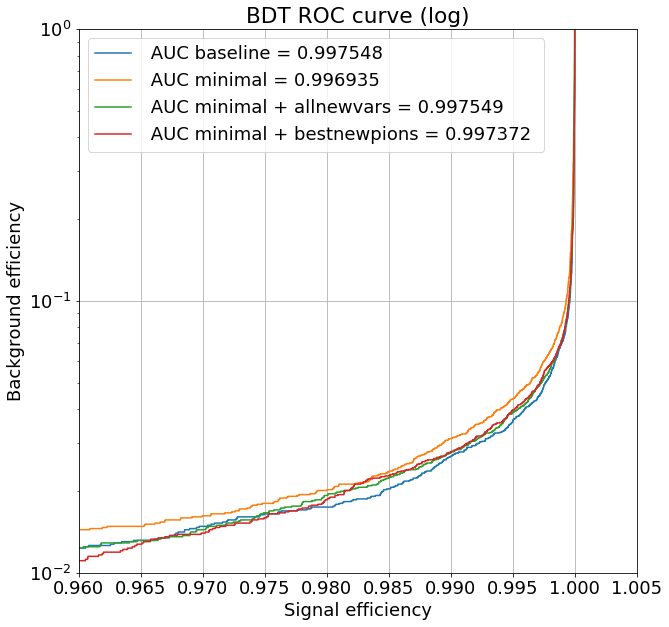

In [44]:
#plot roc curves
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
roc_test={}
roc={}
for i in BDT_list:
    bdt=BDT_list[i]


    fpr, tpr, threshold = roc_curve(y['signal'].astype('int32'),y[bdt['name']], pos_label=1, sample_weight=y['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc = auc(fpr, tpr)
    roc[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    print(bdt['name'])
    print ("AUC Score (Test): {:4%}".format(roc_auc))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(bdt['name'], roc_auc))
    plt.yscale('log')
    plt.xlim(0.96,1.005)
    plt.ylim(1e-2, 1e-0)
    
 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROCall_{}.png'.format(bkg))

baseline
AUC Score (Test): 99.699322%
minimal
AUC Score (Test): 99.625280%
minimal + allnewvars
AUC Score (Test): 99.723410%
minimal + bestnewpions
AUC Score (Test): 99.725429%


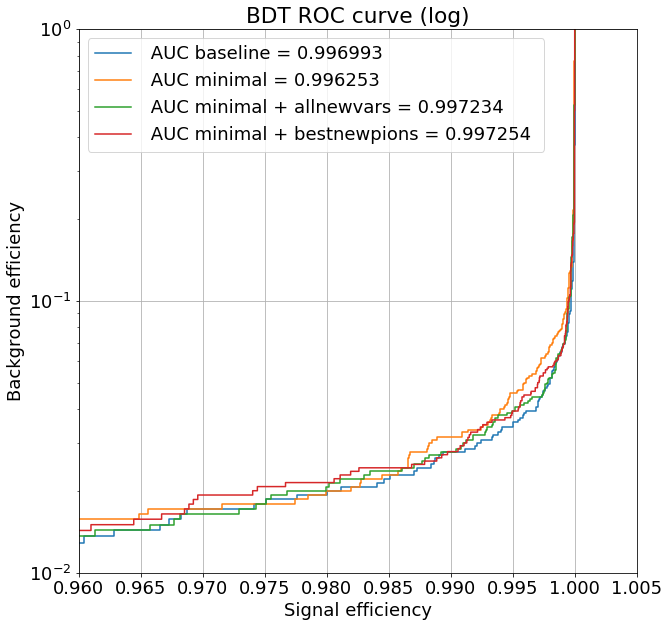

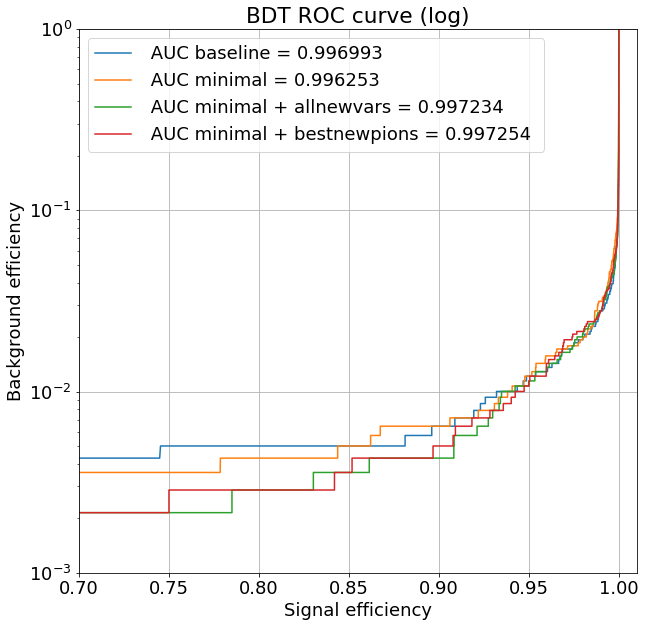

In [45]:
#plot roc curves
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
roc_test={}
roc={}
for i in BDT_list:
    bdt=BDT_list[i]


    fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),y_test[bdt['name']], pos_label=1, sample_weight=y_test['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc_test = auc(fpr, tpr)
    roc_test[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    print(bdt['name'])
    print ("AUC Score (Test): {:4%}".format(roc_auc_test))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(bdt['name'], roc_auc_test))
    plt.yscale('log')
    plt.xlim(0.96,1.005)
    plt.ylim(1e-2, 1e-0)
    
 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROCzoom_{}.png'.format(bkg))

plt.figure(figsize=(10,10))
roc_test={}
for i in BDT_list:
    bdt=BDT_list[i]


    fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),y_test[bdt['name']], pos_label=1, sample_weight=y_test['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc_test = auc(fpr, tpr)
    roc_test[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    #print(bdt['name'])
    #print ("AUC Score (Test): {:4%}".format(roc_auc_test))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(bdt['name'], roc_auc_test))
    plt.yscale('log')
    plt.xlim(0.7,1.01)
    plt.ylim(1e-3, 1e-0)
    fpr, tpr, threshold = roc_curve(y['signal'].astype('int32'),y[bdt['name']], pos_label=1, sample_weight=y['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc= auc(fpr, tpr)
    roc[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})

 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROC_{}.png'.format(bkg))

In [46]:
bkg

'pions'

In [47]:
# calc BDT cut
BDT_cut={}
thr=0.95

for i in BDT_list:
    BDT_cut[i]=np.interp(thr,roc_test[i]['tpr'], roc_test[i]['threshold'])
    """with open(file_name, 'a') as f:
        f.write('BDT cut ={}  for tpr = {} and fpr {}\n'.format( np.interp(thr,roc_test['tpr'], roc_test['threshold']), np.interp(0.95,roc_test['tpr'], roc_test['tpr']), np.interp(0.95,roc_test['tpr'], roc_test['fpr'])))
"""
    print('BDT cut ={}  for tpr = {} and fpr {}'.format( np.interp(thr,roc_test[i]['tpr'], roc_test[i]['threshold']),
                                                        np.interp(thr,roc_test[i]['tpr'], roc_test[i]['tpr']),
                                                        np.interp(thr,roc_test[i]['tpr'], roc_test[i]['fpr'])))

BDT cut =0.9485658083206885  for tpr = 0.95 and fpr 0.012168933428775687
BDT cut =0.9314794495299499  for tpr = 0.95 and fpr 0.012168933428775687
BDT cut =0.943940038073335  for tpr = 0.95 and fpr 0.011453113815318295
BDT cut =0.9445391558041424  for tpr = 0.95 and fpr 0.010737294201860901


In [48]:
#binning y_test


def calctp(group):
    pos=len(group[(group[column]>cutoff) & (group['signal']==1)])
    truepos= len(group[group['signal']==1])
    
    if truepos !=0 :return pos/truepos
    else : return np.nan
def calcfp(group):
    fp = len(group[(group[column]>cutoff) & (group['signal']==0)])
    trueneg = len(group[group['signal']==0])
    if trueneg !=0: return fp/trueneg
    else: return np.nan

In [49]:

#CALCULATE ERROR BARS
conf_level=0.67
from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)/2
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi


In [50]:
BDT_list[i]['name']

'minimal + bestnewpions'

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


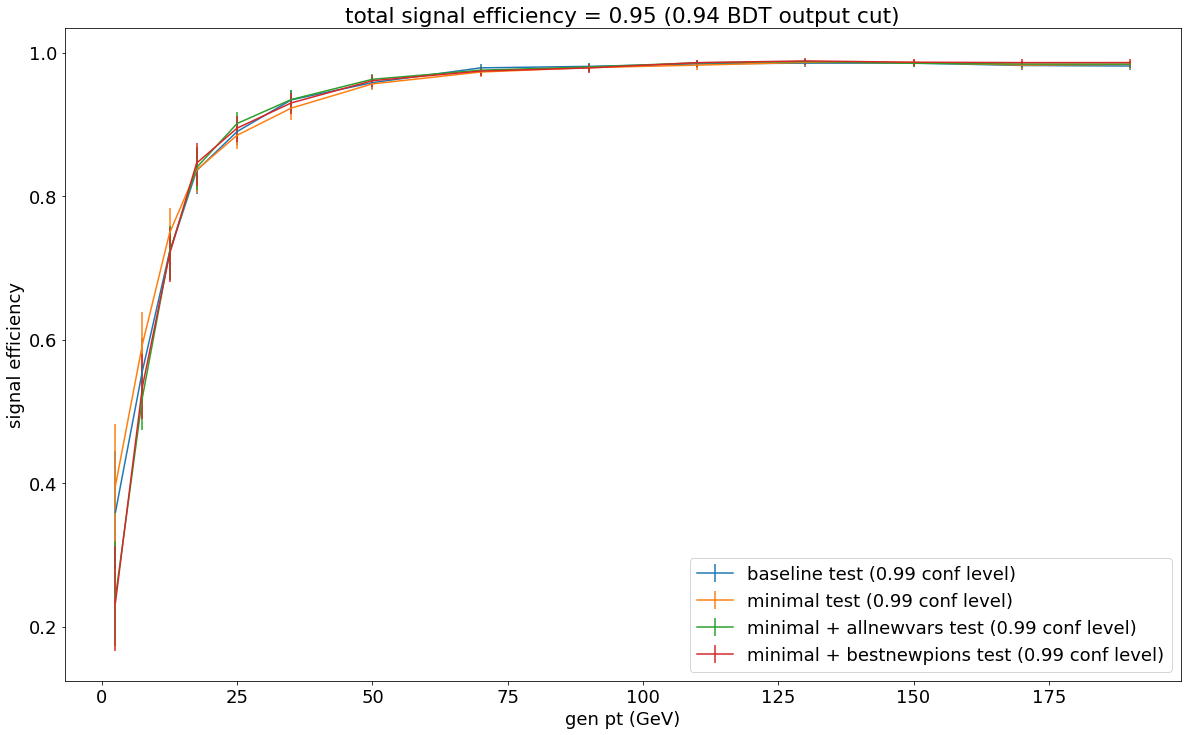

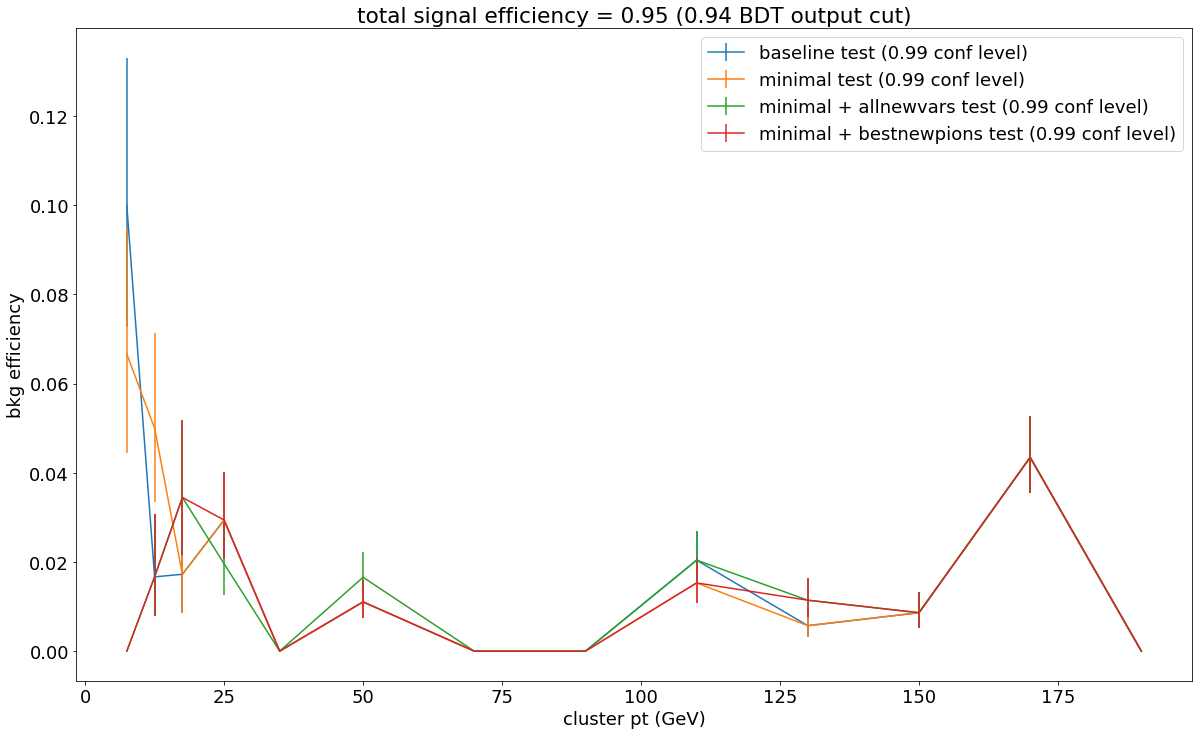

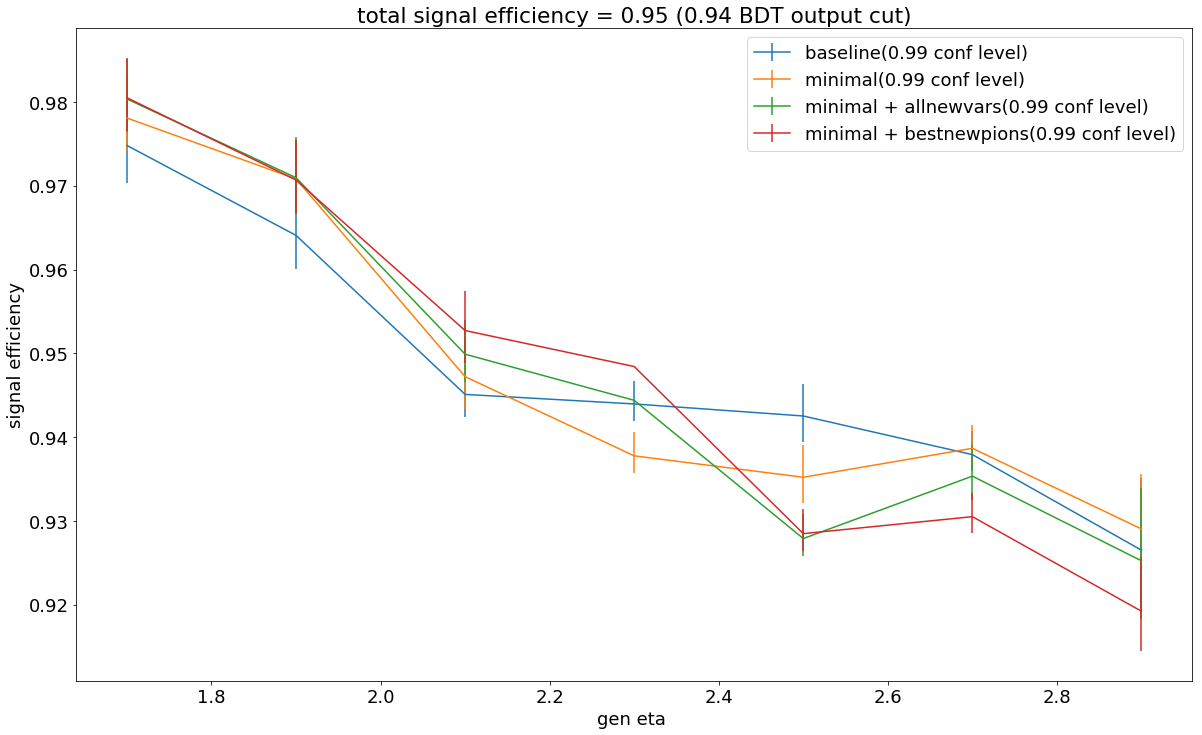

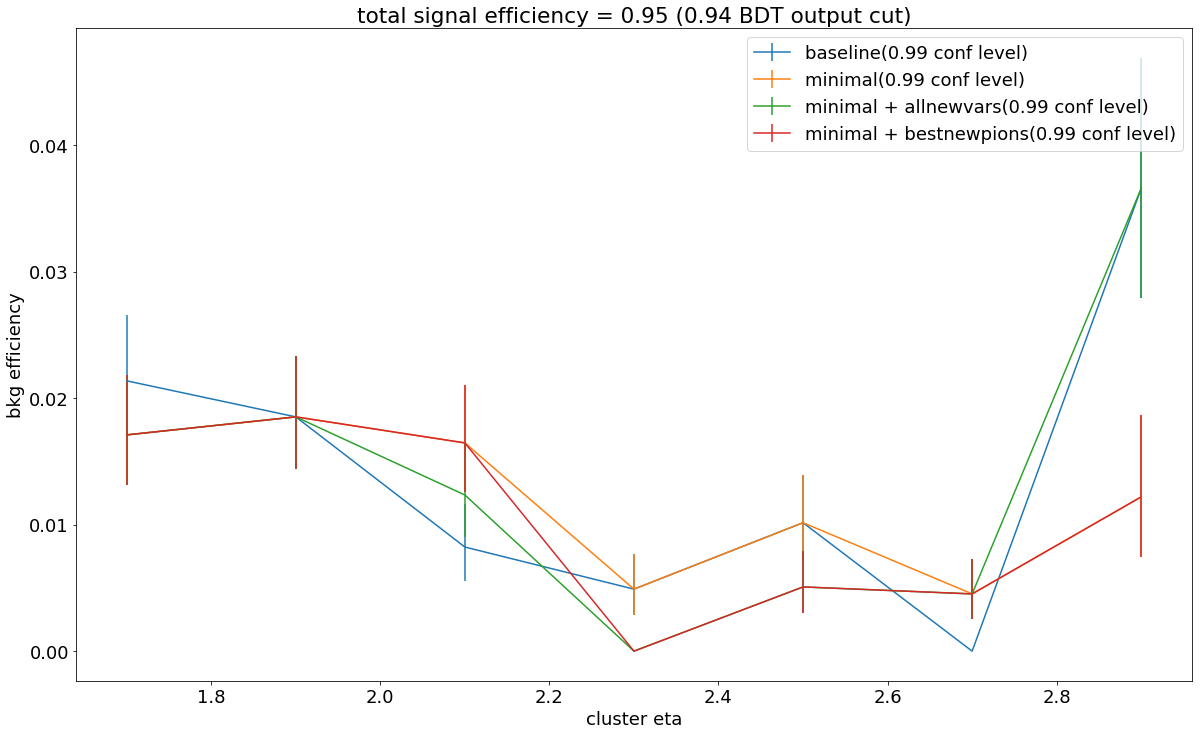

In [51]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
#y_test['BDT']=predictions_BDT_test

"""from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})"""

roc_cut_test={}
y_test['genpt_binned']=pd.cut(y_test['genpart_pt'], pt_bins)
y_test['cl3dpt_binned']=pd.cut(y_test['cl3d_pt'], pt_bins)
y_test['geneta_binned']=pd.cut(np.abs(y_test['genpart_exeta']), eta_bins)
y_test['cl3deta_binned']=pd.cut(np.abs(y_test['cl3d_eta']), eta_bins)

y_train['genpt_binned']=pd.cut(y_train['genpart_pt'], pt_bins)
y_train['cl3dpt_binned']=pd.cut(y_train['cl3d_pt'], pt_bins)
y_train['geneta_binned']=pd.cut(np.abs(y_train['genpart_exeta']), eta_bins)
y_train['cl3deta_binned']=pd.cut(np.abs(y_train['cl3d_eta']), eta_bins)


plt.figure(figsize=(20,12))
for i in BDT_list:
    roc_cut_test[i]=roc_test[i][roc_test[i]['tpr']>thr];

    conf_level=0.99

    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('genpt_binned').size(), tpr, conf_level)
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='{} test ({} conf level)'.format(column,conf_level))
"""    
    group=y_train.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_train.groupby('genpt_binned').size(), tpr, conf_level)
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='{} train ({} conf level)'.format(column,conf_level))
    """
plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}_{}.png'.format(thr, bkg))
    
plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('cl3dpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('cl3dpt_binned').size(), fpr, conf_level)
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='{} test ({} conf level)'.format(column, conf_level))
"""   
    group=y_train.groupby('cl3dpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_train.groupby('cl3dpt_binned').size(), fpr, conf_level)
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='{} train ({} conf level)'.format(column, conf_level))
    """
plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}_{}.png'.format(thr, bkg))


plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('geneta_binned').size(), fpr, conf_level)

    plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column,conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}_{}.png'.format(thr, bkg))

plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('cl3deta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('cl3deta_binned').size(), fpr, conf_level)
    plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column, conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}_{}.png'.format(thr, bkg))


In [52]:
bkg

'pions'

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

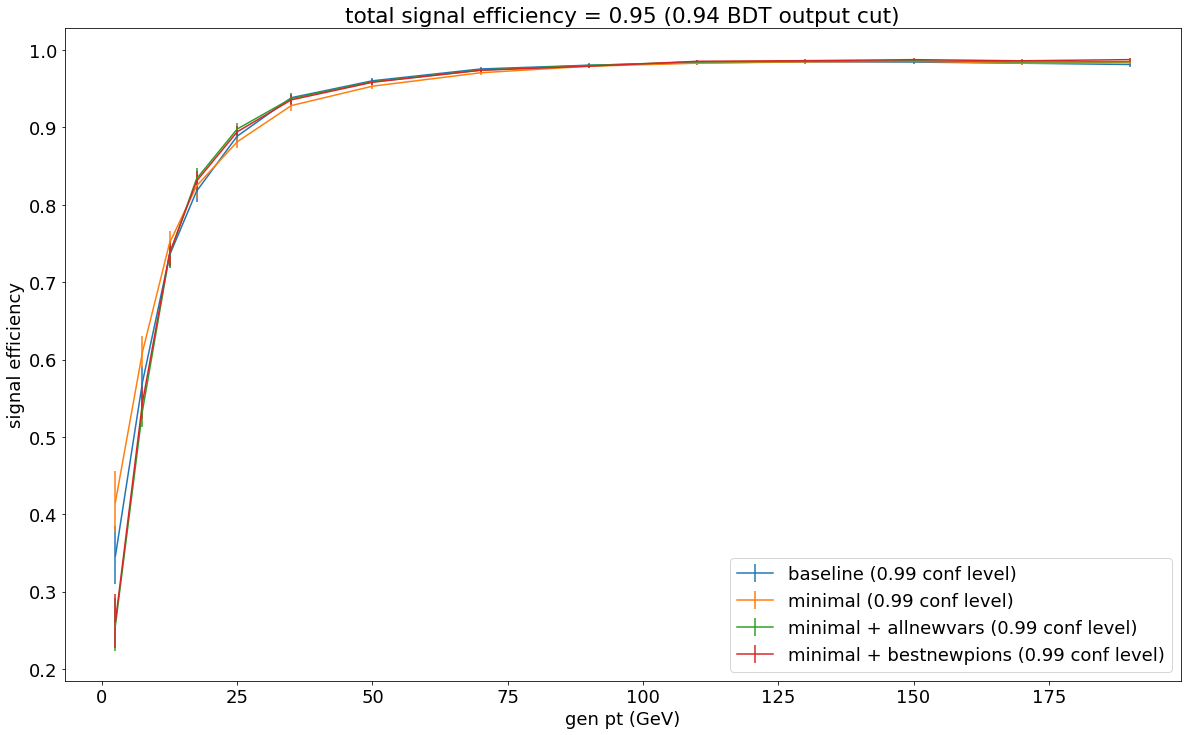

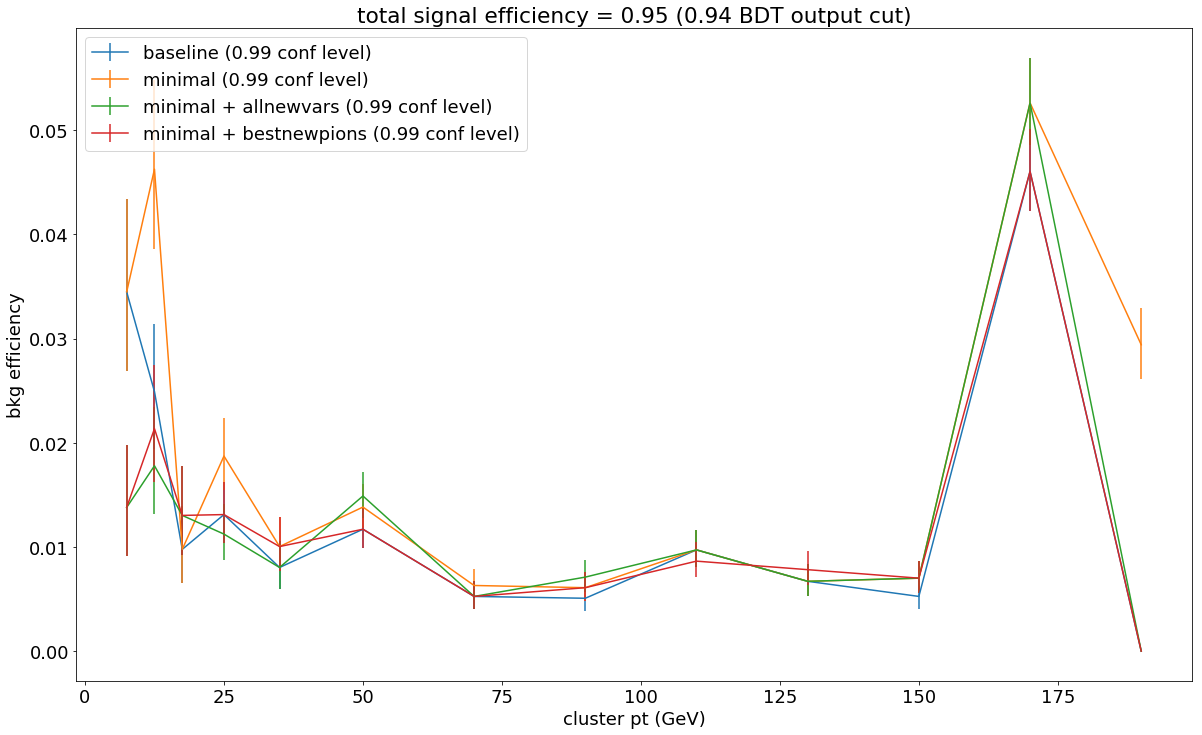

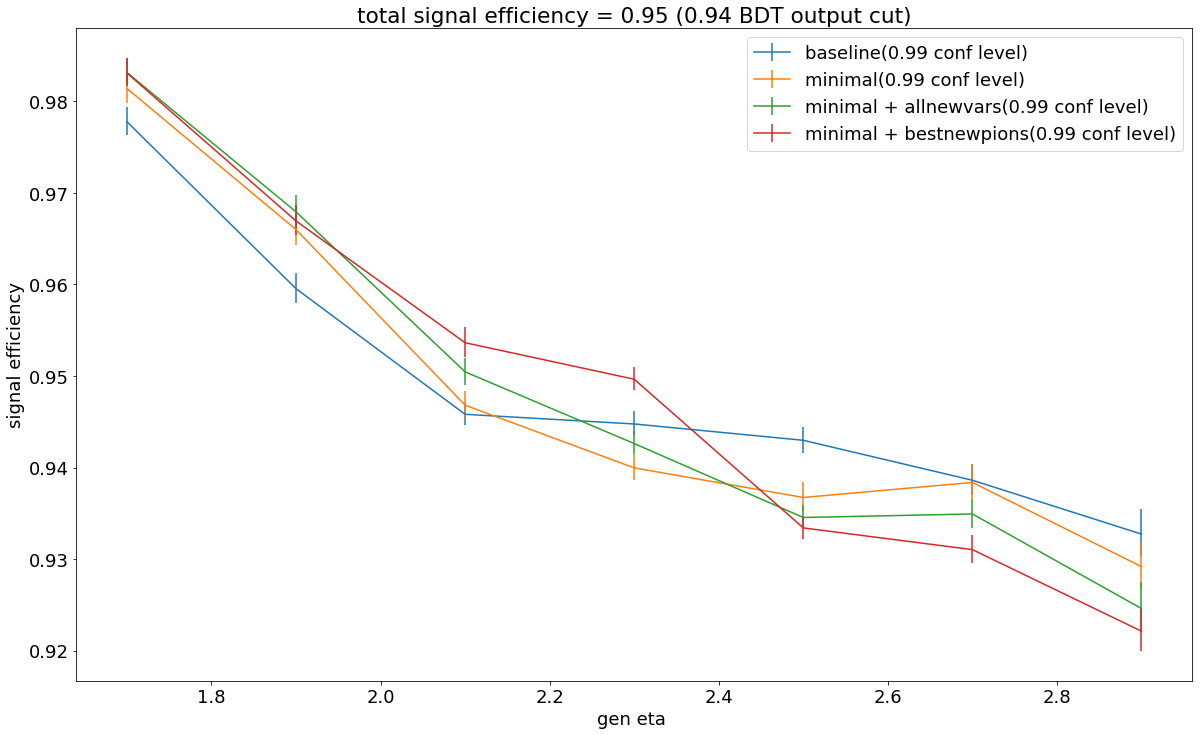

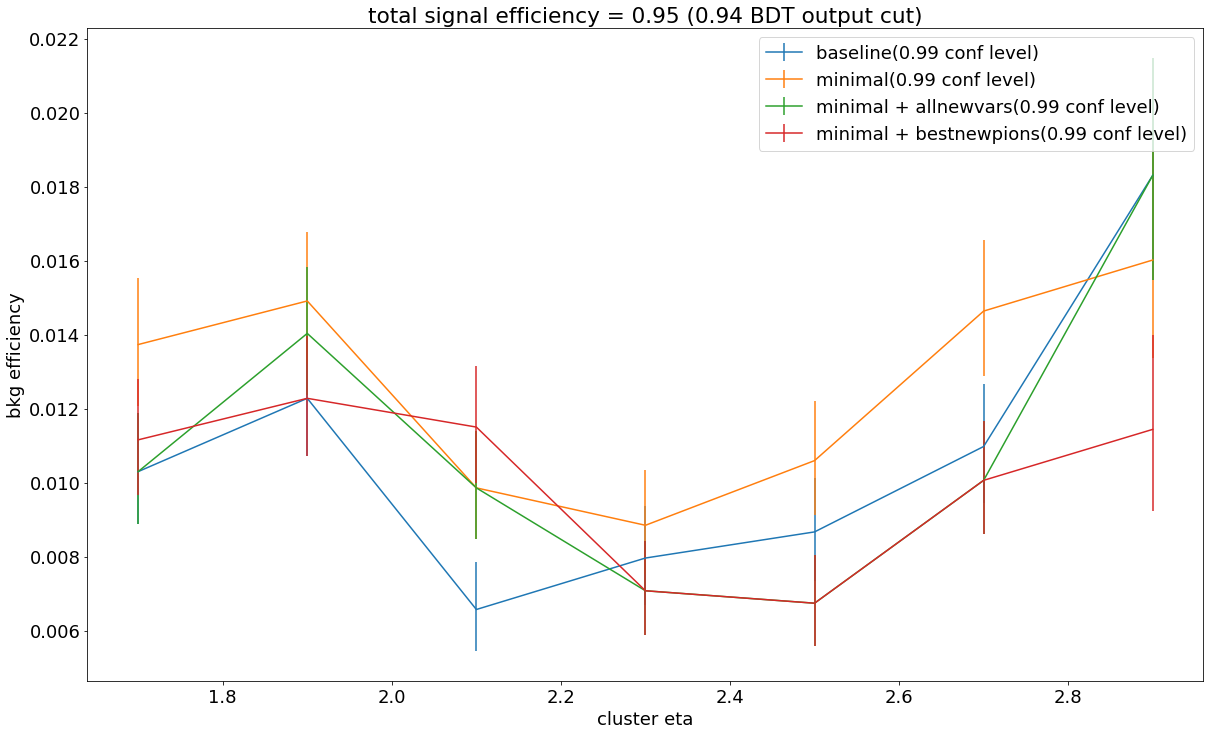

In [53]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
#y_test['BDT']=predictions_BDT_test

"""from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})"""

roc_cut={}
y['genpt_binned']=pd.cut(y['genpart_pt'], pt_bins)
y['cl3dpt_binned']=pd.cut(y['cl3d_pt'], pt_bins)
y['geneta_binned']=pd.cut(np.abs(y['genpart_exeta']), eta_bins)
y['cl3deta_binned']=pd.cut(np.abs(y['cl3d_eta']), eta_bins)


plt.figure(figsize=(20,12))
for i in BDT_list:
    roc_cut[i]=roc[i][roc[i]['tpr']>thr];

    conf_level=0.99

    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('genpt_binned').size(), tpr, conf_level)
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='{} ({} conf level)'.format(column,conf_level))

plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}_{}.png'.format(thr, bkg))
    
plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('cl3dpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('cl3dpt_binned').size(), fpr, conf_level)
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='{} ({} conf level)'.format(column, conf_level))

plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}_{}.png'.format(thr, bkg))


plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('geneta_binned').size(), fpr, conf_level)

    plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column,conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}_{}.png'.format(thr, bkg))

plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('cl3deta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('cl3deta_binned').size(), fpr, conf_level)
    plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column, conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}_{}.png'.format(thr, bkg))


In [54]:
y_test.groupby('cl3dpt_binned').size()

cl3dpt_binned
(0, 5]           0
(5, 10]        810
(10, 15]      1101
(15, 20]      1204
(20, 30]      2484
(30, 40]      2457
(40, 60]      5026
(60, 80]      4932
(80, 100]     4747
(100, 120]    4780
(120, 140]    4704
(140, 160]    4649
(160, 180]    4521
(180, 200]    3994
(200, 220]     916
dtype: int64

#res pion BDT
AUC Score (Test): 99.770155%
AUC Score (Train): 99.903230%
background rejection test = 0.9882920110192837, train = 0.994824909435915
#res PU BDT
AUC Score (Test): 99.901765%
AUC Score (Train): 99.914897%
background rejection test = 0.9994748699879739, train = 0.9995563555778215

In [55]:
df_cut.columns

Index(['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta',
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax',
       ...
       'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0',
       'reverse_ebm1', 'reverse_hbm', 'signal', 'weight'],
      dtype='object', length=103)